# <center> Organizacion de datos </center>
#### <center> Curso Rodriguez </center>
## <center> Trabajo practico I: Reservas de Hotel </center>
#### <center> Integrantes del grupo: </center>


<center>

| Apellido y nombre | Padron |
| - | - |
| Ayala, Camila | 107440 |
| Loscalzo, Melina | 106571 |
| Masri, Noah | 108814 |

</center>

#Ejercicio
Para comenzar, vamos a importar las librerias que utilizaremos

In [1]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import pydotplus

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from six import StringIO
from IPython.display import Image

#modelos y métricas
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from colorama import Fore, Style

In [3]:
mpl.font_manager.get_font_names()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']


# Checkpoint 2 : Árbol de decisión

a. Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold
Cross Validation para obtener la mejor performance. ¿Cuántos folds utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

b. Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.

c. Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).

d. Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.

e. Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

Comenzamos importando el dataset ya trabajado en la seccion anterior

In [4]:
ds = pd.read_csv("https://drive.google.com/uc?export=download&id=1HuOWp-SuBRQrokZkpEWEz2kaloWOJqiR")

# Entrenamiento y prediccion

Copiamos el dataset de entrenamiento ya que no queremos modificar los datos del dataset original. Antes de esto, vamos a quitar las columnas que consideramos que no aportan. 

In [5]:
ds_tree_reservas = ds.copy()

In [6]:
# Quitamos las columnas que consideramos que no aportan al analisis, luego de toda la exploracion inicial
to_drop = ['country', 'reservation_status_date', 'stays_in_weekend_nights', 'arrival_date_year', 'arrival_date_day_of_month', 'id','assigned_room_type', 'days_in_waiting_list', 'company']

Vamos a quitar la columna:
* del pais, ya que contamos con muchos datos muy repetidos sobre los cuales no se puede hallar un patron
* de la fecha del estado de la reserva, ya que es un information leak
* de la cantidad de dias de fin de semana que se reservaron dado su bajisimo coeficiente de correlacion de Pearson con el target, hallado en el checkpoint anterior
* del año de arribo, ya que no consideramos que haya una correlacion con el target al no conocer el pais de origen de los huespedes, y poder correlacionarlo con la situacion socioeconomica de este
* dias en lista de espera ya que no vemos la correlacion que podria haber
* el tipo de cuarto asignado, dado que por si sola no parece aportar mucha informacion
* id, ya que al ser personal de un huesped podria dar resultados erroneos
* company, ya que un porcentaje altisimo de los datos que tenemos de este son nulos

In [7]:
# Quitamos los datos que consideramos extras
ds_tree_reservas.drop(to_drop, axis = 'columns', inplace = True)

Los arboles no soportan variables no numericas (object, string, etc), por lo que se debe manipular de alguna manera las columnas no numericas. Aplicamos a nuestro dataset One Hot Encoding a algunas variables que, o cuentan con menos opciones, o parecen mas importantes.

In [8]:
ds_tree_reservas = pd.get_dummies(ds_tree_reservas, columns=["hotel","deposit_type","customer_type", "market_segment"], drop_first=True)
ds_tree_reservas.head()

,lead_time,arrival_date_month,arrival_date_week_number,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,...,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA
0,49,9,37,2,1,0.0,0,BB,TA/TO,0,...,0,0,1,0,0,0,0,0,0,1
1,4,10,44,1,2,0.0,0,BB,Direct,0,...,0,0,1,0,0,0,0,1,0,0
2,25,10,42,1,2,2.0,0,BB,TA/TO,0,...,0,0,1,0,0,0,0,0,0,1
3,26,12,51,5,2,0.0,0,BB,TA/TO,0,...,0,0,1,0,0,0,0,1,0,0
4,104,3,12,5,2,0.0,0,BB,TA/TO,0,...,0,0,0,1,0,0,0,0,1,0


Para el resto de las variables, realizamos un mappeo de los valores posibles a numeros.

In [9]:

ds_tree_reservas['meal'] = ds_tree_reservas['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

ds_tree_reservas['distribution_channel'] = ds_tree_reservas['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

ds_tree_reservas['reserved_room_type'] = ds_tree_reservas['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
                                                                   'H': 7, 'L': 8, 'P':9})


Cambiamos los valores de la columna agent que solian ser valores nulos, por un 0.

In [10]:
ds_tree_reservas['agent'] = ds_tree_reservas['agent'].replace('No_agent', 0)

Mostramos las primeras 5 filas, para tener una idea general de como quedo el dataset modificado

In [11]:
ds_tree_reservas.head()

,lead_time,arrival_date_month,arrival_date_week_number,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,...,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA
0,49,9,37,2,1,0.0,0,0,2,0,...,0,0,1,0,0,0,0,0,0,1
1,4,10,44,1,2,0.0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,25,10,42,1,2,2.0,0,0,2,0,...,0,0,1,0,0,0,0,0,0,1
3,26,12,51,5,2,0.0,0,0,2,0,...,0,0,1,0,0,0,0,1,0,0
4,104,3,12,5,2,0.0,0,0,2,0,...,0,0,0,1,0,0,0,0,1,0


El siguiente paso es separar nuestro dataset en testeo y entrenamiento, para luego de realizar el arbol poder ver como le fue a este. Para esto primero, debemos separar del dataset la variable target.

In [12]:
#Creo un dataset con los features que voy a usar para clasificar
ds_tree_reservas_x=ds_tree_reservas.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_tree_reservas_y = ds_tree_reservas['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_tree_reservas_x,
                                                    ds_tree_reservas_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Creamos un clasificador con hiperparametros arbitrarios para un primer acercamiento, a ver como nos va.

In [13]:
#Creamos un clasificador con hiperparámetros 
tree_model = tree.DecisionTreeClassifier(criterion="gini",
                                         max_depth = 20, 
                                         min_samples_leaf=10) 

Con este arbol, ya podemos crear un modelo entrenado, y luego usarlo para realizar predicciones sobre nuestro set de testeo, es decir, datos que aun no vio.

In [14]:
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)

#Mostramos los valores predichos
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Creamos una tabla que contiene dos columnas: los datos predichos, y los datos reales, para una primera visualizacion sobre nuestra performance.

In [15]:
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,1,1
7,1,1
8,0,0
9,1,1


##Grafico de la matriz de confusion

Para esta tabla, a continuacion, generaremos y graficaremos la matriz de confusion. Esta matriz tiene como filas los valores reales, y como columnas los predichos. En la posicion superior a la izquierda, podemos ver la cantidad de aciertos negativos que tuvo el modelo (verdaderos negativos; dijo que no cancelaba y no cancelo), mientras que en la parte inferior a la derecha podemos ver los aciertos positivos que tuvo el modelo (verdaderos positivos; dijo que cancelaba y no cancelo). Por el contrario, arriba a la derecha, esta muestra todos los casos en que el modelo cometio un error positivamente (falso positivo; dijo que cancelaba y no cancelo), y abajo a la izquierda los errores negativos (falsos negativos; dijo que no cancelaba y cancelo)

Text(50.722222222222214, 0.5, 'True')

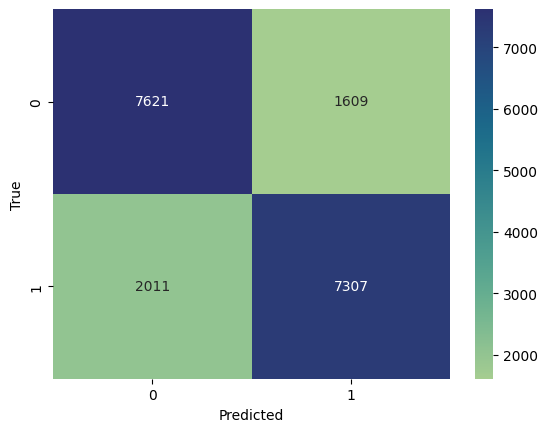

In [16]:
#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Graficamos la matriz de confusión
sns.heatmap(tabla,cmap="crest", annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Breve explicacion de las metricas y su calculo

Las metricas que calcularemos son el accuracy, el recall, la precision y el f1 score:
* Accuracy: esta se calcula como $\frac{TP + TN}{TP + TN + FP + FN}$, es decir, calcula la proporcion de aciertos sobre el total de los datos.
* Recall: esta se calcula como $\frac{TP}{TP + FN}$. A esta tambien se la conoce como True Positive Rate, ya que calcula la cantidad de proporcion de positivos predichos sobre los reales positivos totales que hay.
* Precision: esta se calcula como $\frac{TP}{TP + FP}$. Esta calcula la proporcion de datos que realmente son positivos, dividiendo la cantidad de positivos reales predichos por el modelo, sobre todos los predichos por el modelo.
* F1-score: este se calcula como $\frac{2 \times Precision \times Recall}{Precision + Recall}$. Esta metrica es utilizada para balancear entre precision y recall, ya que queremos que ambas sean lo mas altas posible, y el accuracy no siempre es lo mejor; tiende a fallar mas si el dataset no esta bien balanceado.

In [17]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8048307095104593
Recall: 0.7841811547542391
Precision: 0.8195379093764019
f1 score: 0.801469781726445


Generamos un reporte de todas las metricas obtenidas con este primer arbol sobre el dataset de testeo.

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      9230
           1       0.82      0.78      0.80      9318

    accuracy                           0.80     18548
   macro avg       0.81      0.80      0.80     18548
weighted avg       0.81      0.80      0.80     18548



Se puede observar que los valores obtenidos son muy elevados, pero esto podria deberse a la profundidad del arbol, a que estamos generando overfitting, a pesar de que estos datos no los habia visto antes.

# Graficamos el Árbol

Realizamos un grafico de este primer arbol para ver que variables aparecen cerca de la raiz, para ver cuan relevantes parecen ser.

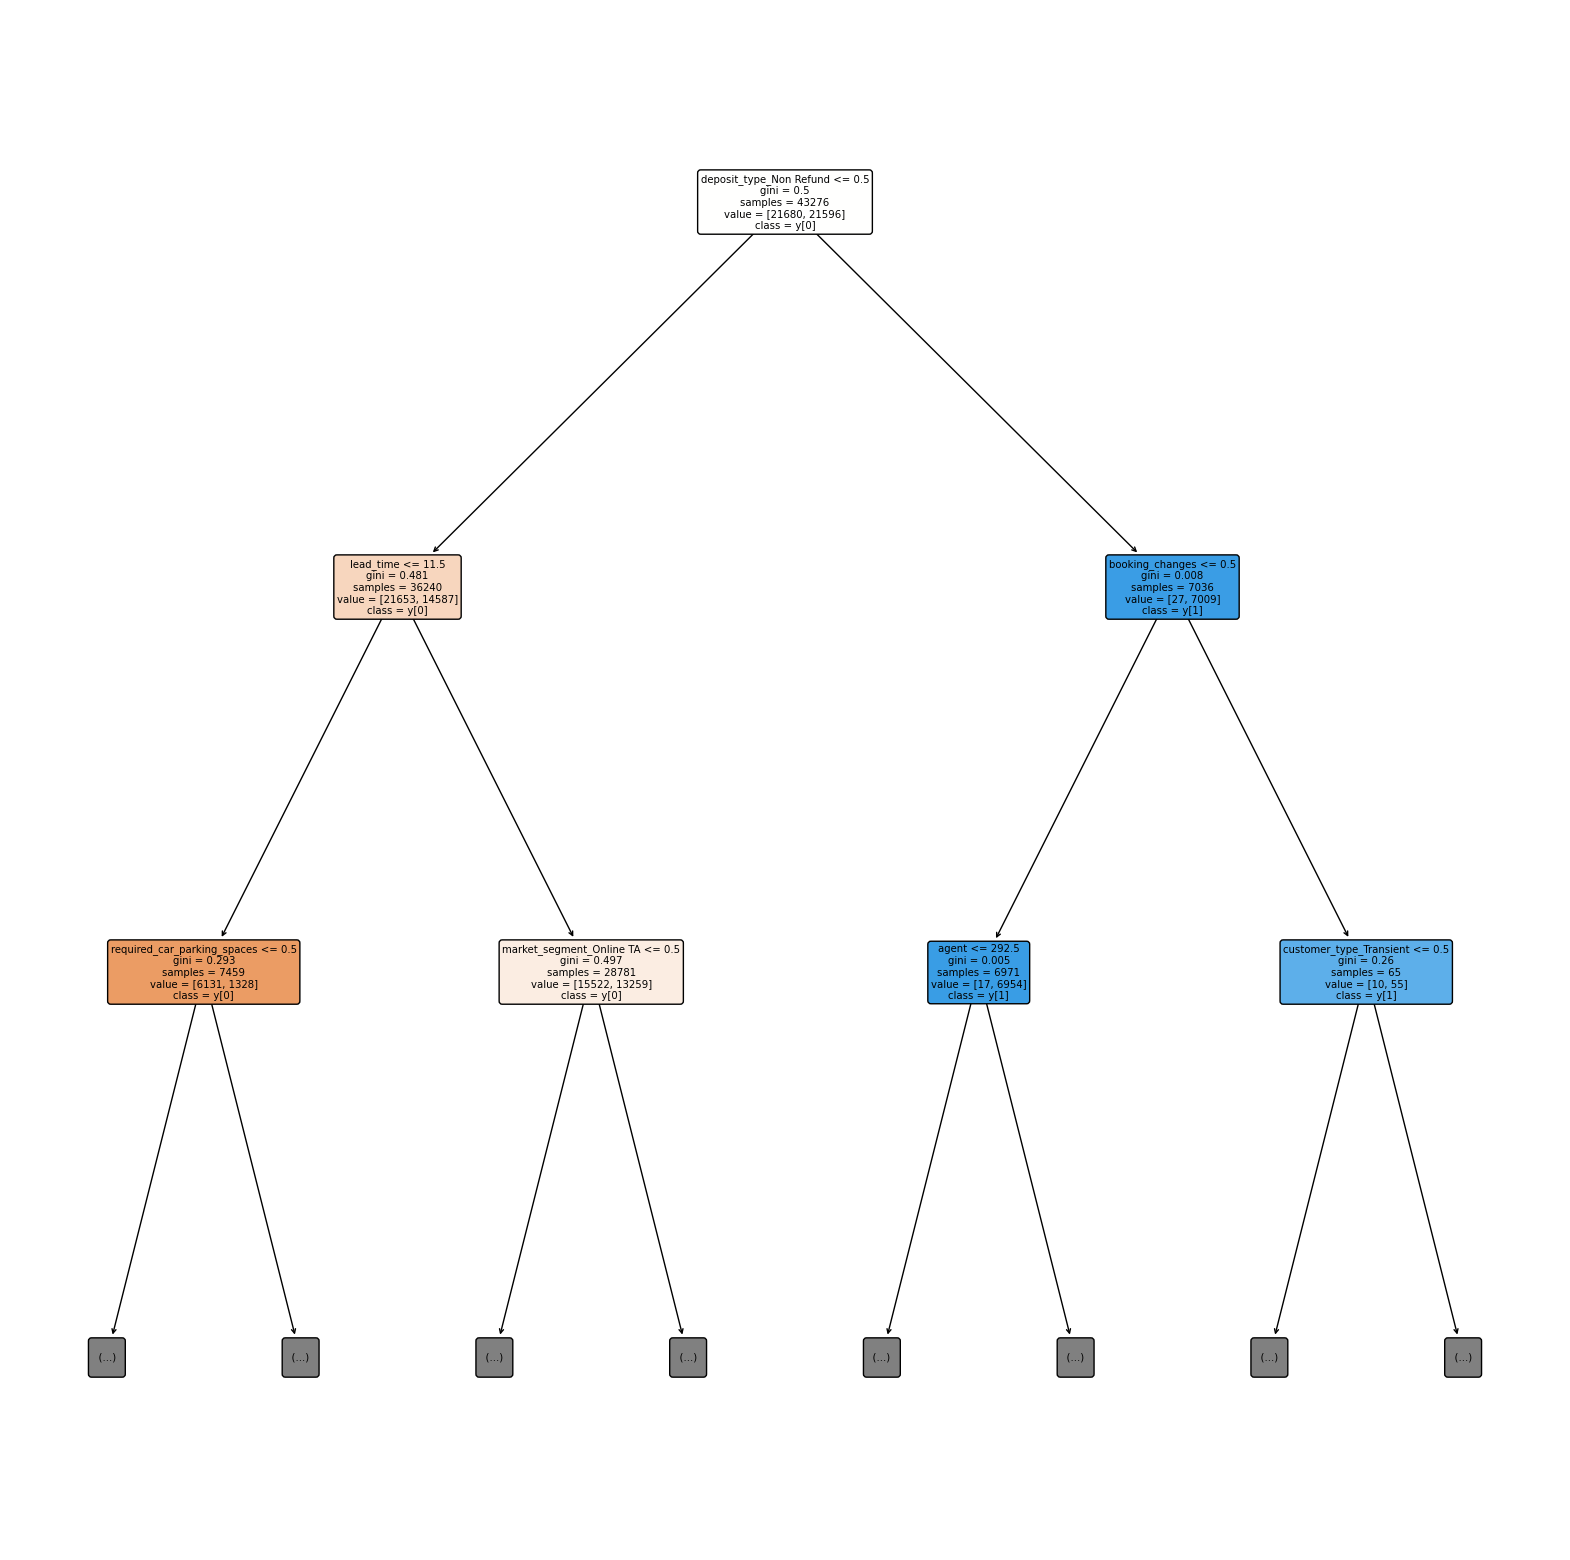

In [19]:
plt.figure(figsize=(20,20))

tree_plot=tree.plot_tree(model,
                         max_depth=2,
                         feature_names=ds_tree_reservas_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

**Buscaremos optimizar los hiperparametros mediante K-fold cross validations.**

# Modelo 1: Tree Decision(K-Fold: 5 Folds)

En esta etapa, usaremos KFolds para realizar Random Cross Validation. Optamos por arrancar con un numero de 5 folds ya que este es el estandar que suele funcionar para muchos datasets. En primer lugar, vamos a elegir los parametros.

In [20]:
#Cantidad de combinaciones que quiero probar
n=10

#Cantidad de conjuntos que separo para el Cross Validation
folds=5

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,12))}

#Metrica que quiero optimizar
scorer_fn = make_scorer(sk.metrics.f1_score)

Luego comenzamos a crear todo lo que vamos a usar, y finalmente, realizamos el cross validation. Optamos por usar Kfolds estratificado para que los conjuntos esten balanceados, es decir, que haya una proporcion similar de casos positivos en cada subconjunto.

In [21]:
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, 
                              random_state=42) #plantamos la semilla para que nos den siempre los mismos hiperparametros

#Entrenamos al random search
randomcv.fit(X =x_train, y = y_train);

Finalmente, mostramos los mejores hiperparametros encontrados para este KFolds

In [22]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)

#Mejor métrica
print(randomcv.best_score_)


{'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.7180220086824803


In [23]:
randomcv.cv_results_['mean_test_score']

array([0.48957262, 0.48957262, 0.48957262, 0.48957262, 0.71802201,
       0.48957262, 0.48957262, 0.48957262, 0.70507072, 0.48957262])

##Predicción y Evaluación del Modelo con mejores hiperparámetros

**Creamos el arbol, lo entrenamos y predecimos los valores de test**

Separamos las columnas que seran las que nuestro arbol tendra en cuenta al imprimir

In [24]:
nombres_cols = list(ds_tree_reservas_x)

Generamos ahora con los mejores hiperparametros obtenidos nuestro arbol, y luego imprimimos por pantalla sus reglas.

In [25]:
#Creamos un clasificador con hiperparámetros 
tree_best=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entrenamos el modelo
tree_best.fit(X =x_train, y = y_train)

reglas = export_text(tree_best, feature_names=list(nombres_cols))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 7.50
|   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |--- lead_time <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- lead_time >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- total_of_special_requests >  0.50
|   |   |   |   |--- adr <= 51.78
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- adr >  51.78
|   |   |   |   |   |--- class: 0
|   |   |--- lead_time >  7.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- total_of_special_requests >  0.50
|   |   |   |   |   |--- class: 0
|   |--- required_car_

Graficamos el arbol generado

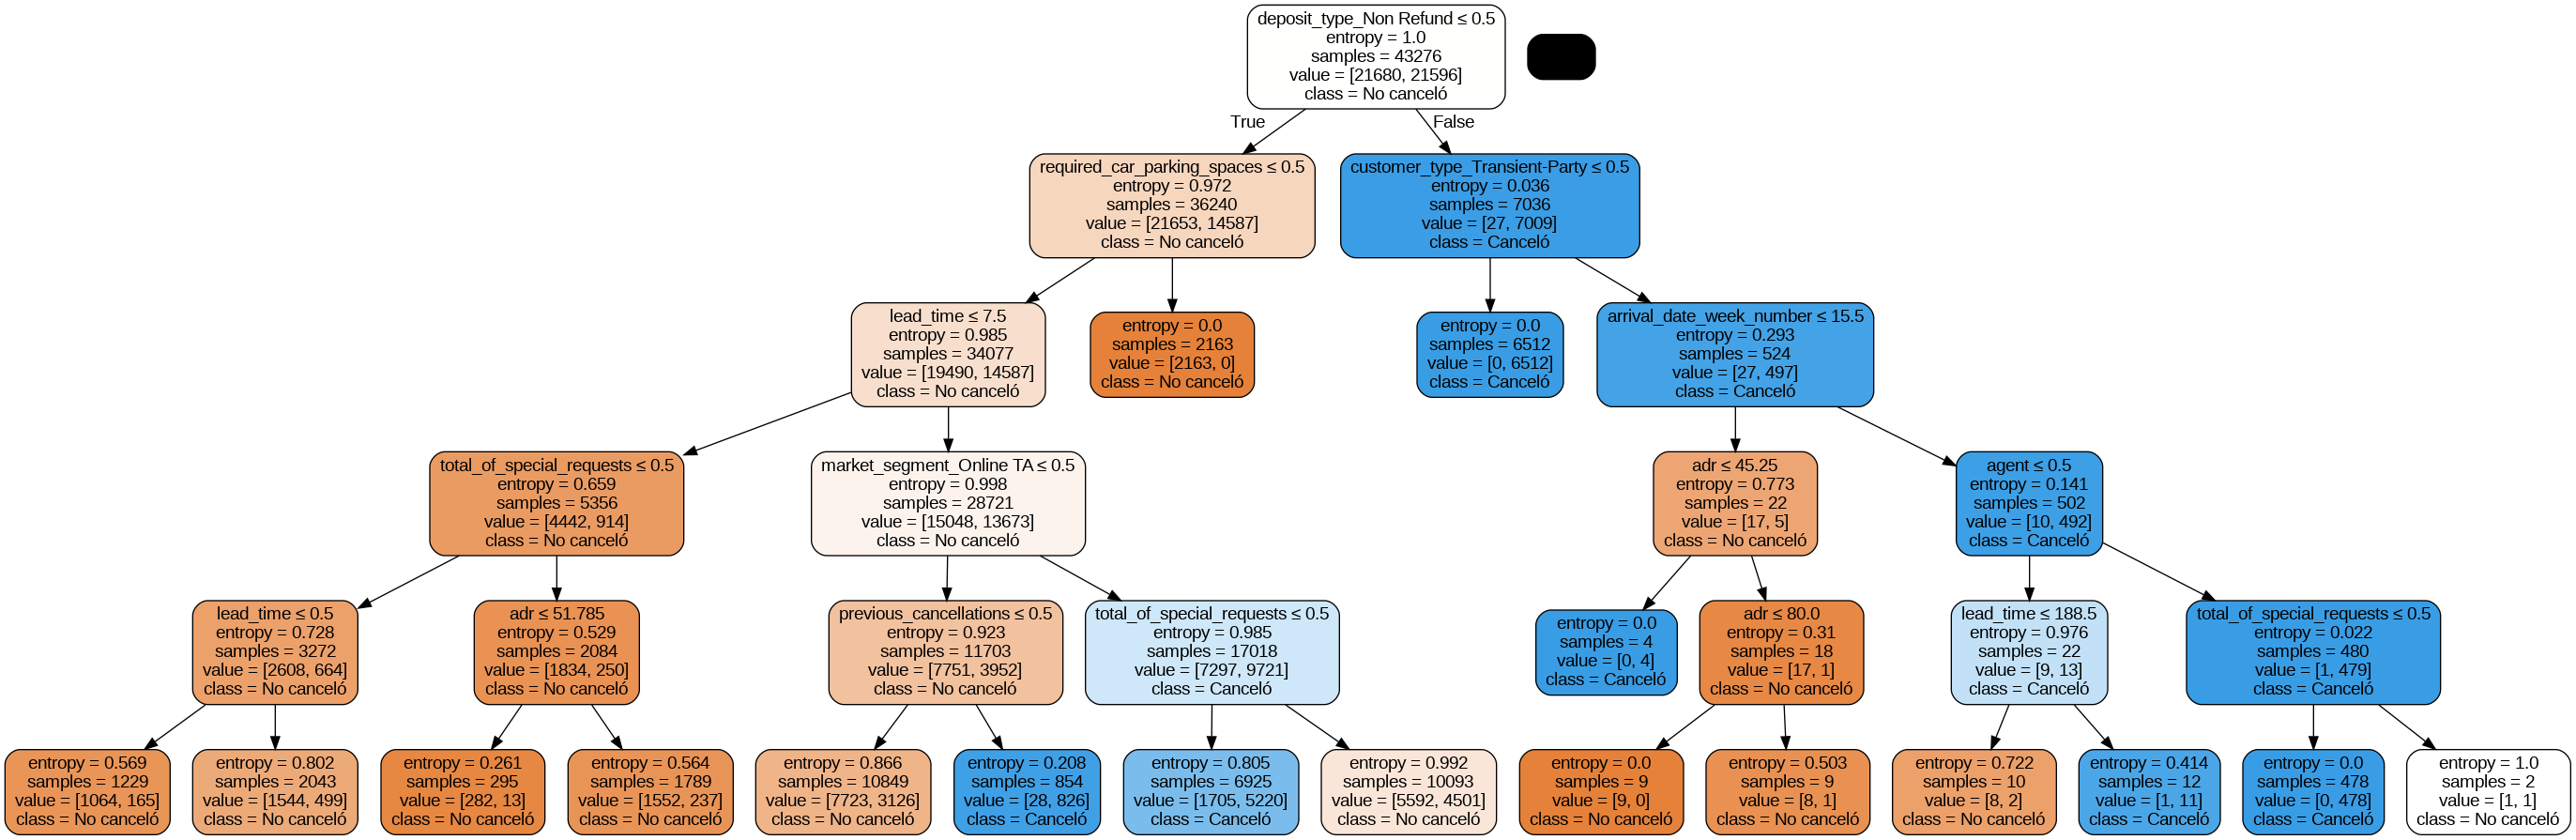

In [26]:
dot_data = StringIO()
export_graphviz(tree_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=nombres_cols,
                class_names=['No canceló','Canceló'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

##Evaluamos el mejor árbol con los hiperparametros

A continuacion calculamos las metricas obtenidas en las predicciones del dataset de testeo.

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      9230
           1       0.88      0.62      0.73      9318

    accuracy                           0.77     18548
   macro avg       0.79      0.77      0.76     18548
weighted avg       0.79      0.77      0.76     18548

F1-Score: 0.7265713924370811


Text(50.722222222222214, 0.5, 'True')

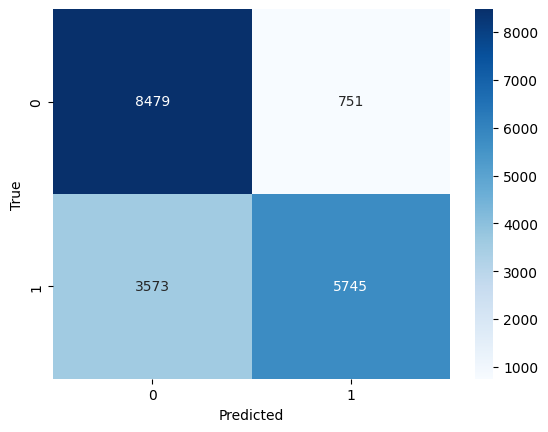

In [27]:
#Realizamos predicción sobre el set de evaluacion
y_pred = tree_best.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Por el otro lado, tambien debemos ver como le va con nuestro dataset de entrenamiento, ya que si le va mucho mejor sabemos que se esta "aprendiendo los datos de memoria".

In [28]:
print(classification_report(y_train, tree_best.predict(x_train)))
print('F1-Score: {}'.format(f1_score(y_train, tree_best.predict(x_train), average='binary')))

              precision    recall  f1-score   support

           0       0.70      0.92      0.80     21680
           1       0.88      0.60      0.72     21596

    accuracy                           0.76     43276
   macro avg       0.79      0.76      0.76     43276
weighted avg       0.79      0.76      0.76     43276

F1-Score: 0.717462411698414


Las metricas dan en ambos casos muy similares, por lo que asumimos que no esta sucediendo eso.

# Modelo 2: Tree Decision(K-Fold: 4 Folds)

Buscamos otro set de hiperparametros usando otra cantidad de folds en la cross validation.

Por esta razón, repetimos el proceso anterior, esta vez realizando 4 folds en vez de 5, a ver como varian nuestras metricas. Hacemos exactamente el mismo analisis

In [29]:
#Especificamos la cantidad de combinaciones a probar
n=8
                
#Cantidad de splits para el Cross Validation
folds=4

#Kfold estratificado
kfoldcv2 = StratifiedKFold(n_splits=folds)

#Random Search Cross Validation
randomcv2 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv2,
                              n_iter=n,
                              random_state=110) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv2.fit(X =x_train, y = y_train)

#Mejores hiperparametros del arbol
print(randomcv2.best_params_)

#Mejor métrica
print(randomcv2.best_score_)


{'max_depth': 9, 'criterion': 'entropy', 'ccp_alpha': 0.011111111111111112}
0.7170898417689995


In [30]:
randomcv2.cv_results_['mean_test_score']

array([0.71708984, 0.48957474, 0.48957474, 0.48957474, 0.7105292 ,
       0.71708984, 0.48957474, 0.48957474])

## Evaluamos el mejor árbol con los hiperparametros

In [31]:
#Creamos un clasificador con hiperparámetros 
tree_best2=DecisionTreeClassifier().set_params(**randomcv2.best_params_)

#Entrenamos el modelo
tree_best2.fit(X =x_train, y = y_train)

reglas = export_text(tree_best2, feature_names=list(nombres_cols))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 7.50
|   |   |   |--- class: 0
|   |   |--- lead_time >  7.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- total_of_special_requests >  0.50
|   |   |   |   |   |--- class: 0
|   |--- required_car_parking_spaces >  0.50
|   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- class: 1



              precision    recall  f1-score   support

           0       0.70      0.92      0.80      9230
           1       0.88      0.62      0.73      9318

    accuracy                           0.77     18548
   macro avg       0.79      0.77      0.76     18548
weighted avg       0.79      0.77      0.76     18548

F1-Score: 0.7263650151668352


Text(50.722222222222214, 0.5, 'True')

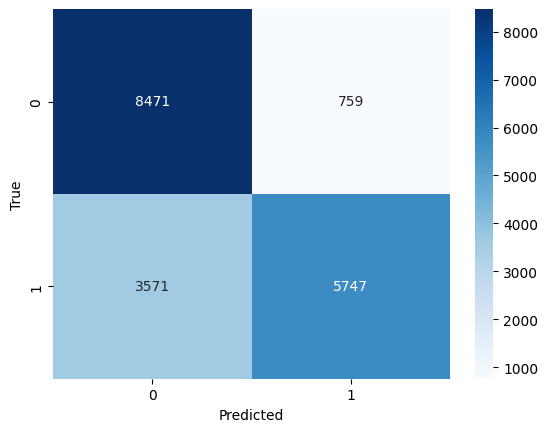

In [32]:
y_pred = tree_best2.predict(x_test)

print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Al graficar esta matriz de confusion, vemos que excepto por 4 casos, tuvo un desempeño exactamente igual que el anterior

In [33]:
print(classification_report(y_train, tree_best2.predict(x_train)))
print('F1-Score: {}'.format(f1_score(y_train, tree_best2.predict(x_train), average='binary')))

              precision    recall  f1-score   support

           0       0.70      0.92      0.79     21680
           1       0.88      0.60      0.72     21596

    accuracy                           0.76     43276
   macro avg       0.79      0.76      0.76     43276
weighted avg       0.79      0.76      0.76     43276

F1-Score: 0.7170909889868446


Dado que el tamaño de este segundo arbol obtenido es mayor para unas metricas casi iguales, por el momento nos quedamos con el primer arbol.

# Modelo 3: Tree Decision(K-Fold: 6 Folds)

Buscamos otro set de hiperparametros usando otra cantidad de folds en la cross validation.

In [34]:
#Cantidad de combinaciones que quiero probar
n=12

#Cantidad de splits para el Cross Validation
folds=6

#Kfold estratificado
kfoldcv3 = StratifiedKFold(n_splits=folds)

#Random Search Cross Validation, usando el mismo base tree, los mismos rangos de hiperparametros y la misma metrica a tener en cuenta
randomcv3 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv3,
                              n_iter=n, 
                              random_state=230) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv3.fit(X =x_train, y = y_train)

#Mejores hiperparametros del arbol
print(randomcv3.best_params_)

#Mejor métrica
print(randomcv3.best_score_)




{'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0.005555555555555556}
0.7329653784065492


In [35]:
randomcv3.cv_results_['mean_test_score']

array([0.48957626, 0.48957626, 0.48957626, 0.48957626, 0.48957626,
       0.48957626, 0.71708724, 0.48957626, 0.48957626, 0.71708724,
       0.71708724, 0.73296538])

## Evaluamos el mejor árbol con los hiperparametros

In [36]:
#Creamos un clasificador con hiperparámetros 
tree_best3=DecisionTreeClassifier().set_params(**randomcv3.best_params_)

#Entrenamos el modelo
tree_best3.fit(X =x_train, y = y_train)

reglas = export_text(tree_best3, feature_names=list(nombres_cols))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 7.50
|   |   |   |--- class: 0
|   |   |--- lead_time >  7.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- class: 1
|   |--- required_car_parking_spaces >  0.50
|   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- class: 1



              precision    recall  f1-score   support

           0       0.76      0.66      0.71      9230
           1       0.70      0.79      0.74      9318

    accuracy                           0.73     18548
   macro avg       0.73      0.73      0.72     18548
weighted avg       0.73      0.73      0.72     18548

F1-Score: 0.7431489533825463


Text(50.722222222222214, 0.5, 'True')

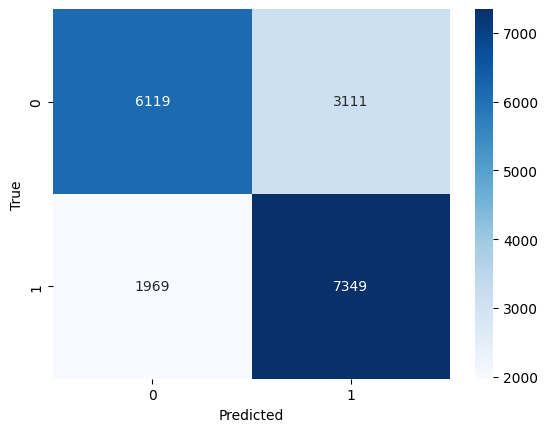

In [37]:
#Evalúo el Arbol con los mejores hiperparámetros
from sklearn.metrics import confusion_matrix, classification_report , f1_score

#Hago predicción sobre el set de evaluacion
y_pred = tree_best3.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Este reporte visualiza las métricas con los datos sobre los que se entreno el modelo

In [38]:
print(classification_report(y_train, tree_best3.predict(x_train)))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70     21680
           1       0.70      0.77      0.73     21596

    accuracy                           0.72     43276
   macro avg       0.72      0.72      0.72     43276
weighted avg       0.72      0.72      0.72     43276



Vemos que este nuevo arbol tiene un F1 score mas elevado que el primero y que el segundo, pero tiene una cantidad inmensa de falsos positivos: opta constantemente porque el huesped cancelo. Aun no tomamos una decision: buscaremos un ultimo modelo.

# Modelo 4: Tree Decision (Grid Search) 

Probaremos ahora ver si contamos con mejor suerte con el metodo de grid search,que busca todas las combinaciones de los parametros que elegimos y no solo algunas aleatorias. Queremos ver si, a pesar de ser mas lento, logra mejorar nuestras metricas de una forma que haga que valgan la pena.

In [39]:
# Construir parámetros de búsqueda
dt_params = {
    'max_depth':[4,6,8],
    'max_features' : [0.5, 0.7, 0.9],
    'min_samples_split': [2, 5, 10, 25], 
    'min_samples_leaf': [1, 2, 5]
}

# Realizar búsqueda en cuadrícula con validación cruzada
tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=293,max_depth=8),
                 dt_params,
                 cv = 5,
                 scoring = 'f1',
                 n_jobs=-1)
dt = tree_gs.fit(X =x_train, y = y_train)
#Mejores hiperparametros del arbol
print(tree_gs.best_params_)

#Mejor métrica
print(tree_gs.best_score_)

{'max_depth': 4, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.7546953444071323


**Observación:**

El modelo entrenado con estos hiperparámetros tiene una profundidad máxima de 4, lo que significa que el árbol tiene 4 niveles. Además, se utilizó un valor de 0.7 para el parámetro "max_features", lo que sugiere que se utilizaron el 70% de las características disponibles para la construcción de cada árbol. Por otro parte, se estableció que el número mínimo de muestras necesarias para dividir un nodo interno es de 5, y que cada hoja debe tener al menos 2 muestras.

En el caso de la métrica F1 obtenida en este caso fue de 0.754, lo cual indica que el modelo es capaz de predecir correctamente el 75.4% de las reservas de hoteles en el conjunto de datos de prueba.

Pasaremos ahora a testear su rendimiento en nuestros conjuntos

In [40]:
# Evaluar el modelo en el conjunto de prueba
y_pred = dt.predict(x_test)
test_f1 = f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      9230
           1       0.72      0.81      0.76      9318

    accuracy                           0.75     18548
   macro avg       0.75      0.74      0.74     18548
weighted avg       0.75      0.75      0.74     18548

F1-Score: 0.7621969620762499


Text(50.722222222222214, 0.5, 'True')

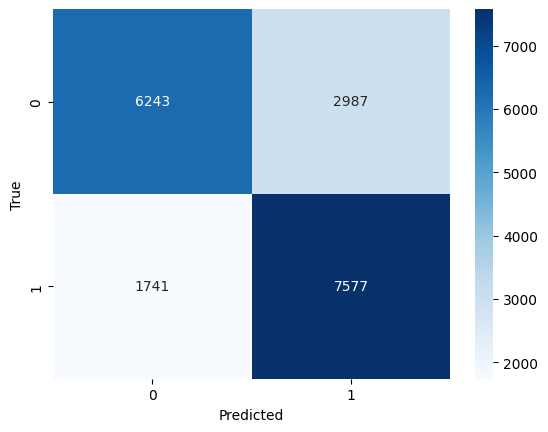

In [41]:
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Vemos que la mayor parte de las metricas mejoraron considerablemente, y a su vez seguimos contando con un arbol de tamaño pequeño, por lo que continuaremos con el analisis de este.

In [42]:
print(classification_report(y_train, dt.predict(x_train)))
print('F1-Score: {}'.format(f1_score(y_train, dt.predict(x_train), average='binary')))

              precision    recall  f1-score   support

           0       0.78      0.68      0.72     21680
           1       0.71      0.80      0.76     21596

    accuracy                           0.74     43276
   macro avg       0.74      0.74      0.74     43276
weighted avg       0.74      0.74      0.74     43276

F1-Score: 0.7553233180927498


Vemos que obtuvimos metricas similares con nuestro dataset de entrenamiento, por lo que proseguimos tranquilamente.

##Predicción y Evaluación del Modelo con mejores hiperparámetros, dado Grid Search

**Creamos el arbol, lo entrenamos y predecimos los valores de test**

In [43]:
#Creamos un clasificador con hiperparámetros 
grid_tree_best=DecisionTreeClassifier().set_params(**tree_gs.best_params_)

#Entrenamos el modelo
grid_tree_best.fit(X =x_train, y = y_train)

#Realizamos una predicción sobre el set de test
y_pred_grid_tree_best = grid_tree_best.predict(x_test)

reglas = export_text(grid_tree_best, feature_names=list(nombres_cols))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- lead_time <= 11.50
|   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |--- lead_time <= 6.50
|   |   |   |   |--- class: 0
|   |   |   |--- lead_time >  6.50
|   |   |   |   |--- class: 0
|   |   |--- required_car_parking_spaces >  0.50
|   |   |   |--- class: 0
|   |--- lead_time >  11.50
|   |   |--- market_segment_Online TA <= 0.50
|   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |--- class: 1
|   |   |--- market_segment_Online TA >  0.50
|   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- required_car_parking_spaces >  0.50
|   |   |   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- booking_changes <= 0.50
|   |   |--- agent <= 292.50
|   |   |   |--- market_segment_Direct <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- market_segment_Direct >  0.50
|   |   |   |   

**Observaciones sobre las reglas**

 Las reglas se basan en las características de las reservas, como el tipo de depósito, la cantidad de tiempo entre la reserva y la fecha de llegada, la cantidad de cambios realizados en la reserva, entre otros.

La primera regla indica que si el tipo de depósito es diferente de "Non Refund" (es decir, es "Refundable"), y la cantidad de tiempo entre la reserva y la fecha de llegada es menor o igual a 11,5 días, y no se requiere estacionamiento para autos, y no ha habido cancelaciones anteriores, entonces la reserva no se cancelará.

La segunda regla indica que si el tipo de depósito es diferente de "Non Refund" y la cantidad de cambios realizados en la reserva es menor o igual a 0,5, y el agente que realiza la reserva tiene un valor menor o igual a 292,5, y el mercado segmento de reservas es "Directo", entonces la reserva no se cancelará.

En sintesis, las reglas indican que las reservas que son refundables, tienen menos tiempo de anticipación entre la reserva y la llegada, no requieren estacionamiento para autos, y no han tenido cancelaciones previas, tienen menos probabilidades de cancelarse. También se puede observar que la regla indica que si el agente que realiza la reserva tiene un valor mayor a 292,5, las reservas tienen más probabilidades de cancelarse. Esto ultimo parece ser un poco arbitrario, dado que los agentes no tienen un orden de enumeracion, y que una gran cantidad son parte del 0, ya que no tienen agente y debimos rellenar sus valores nulos.

#Grafico del mejor arbol

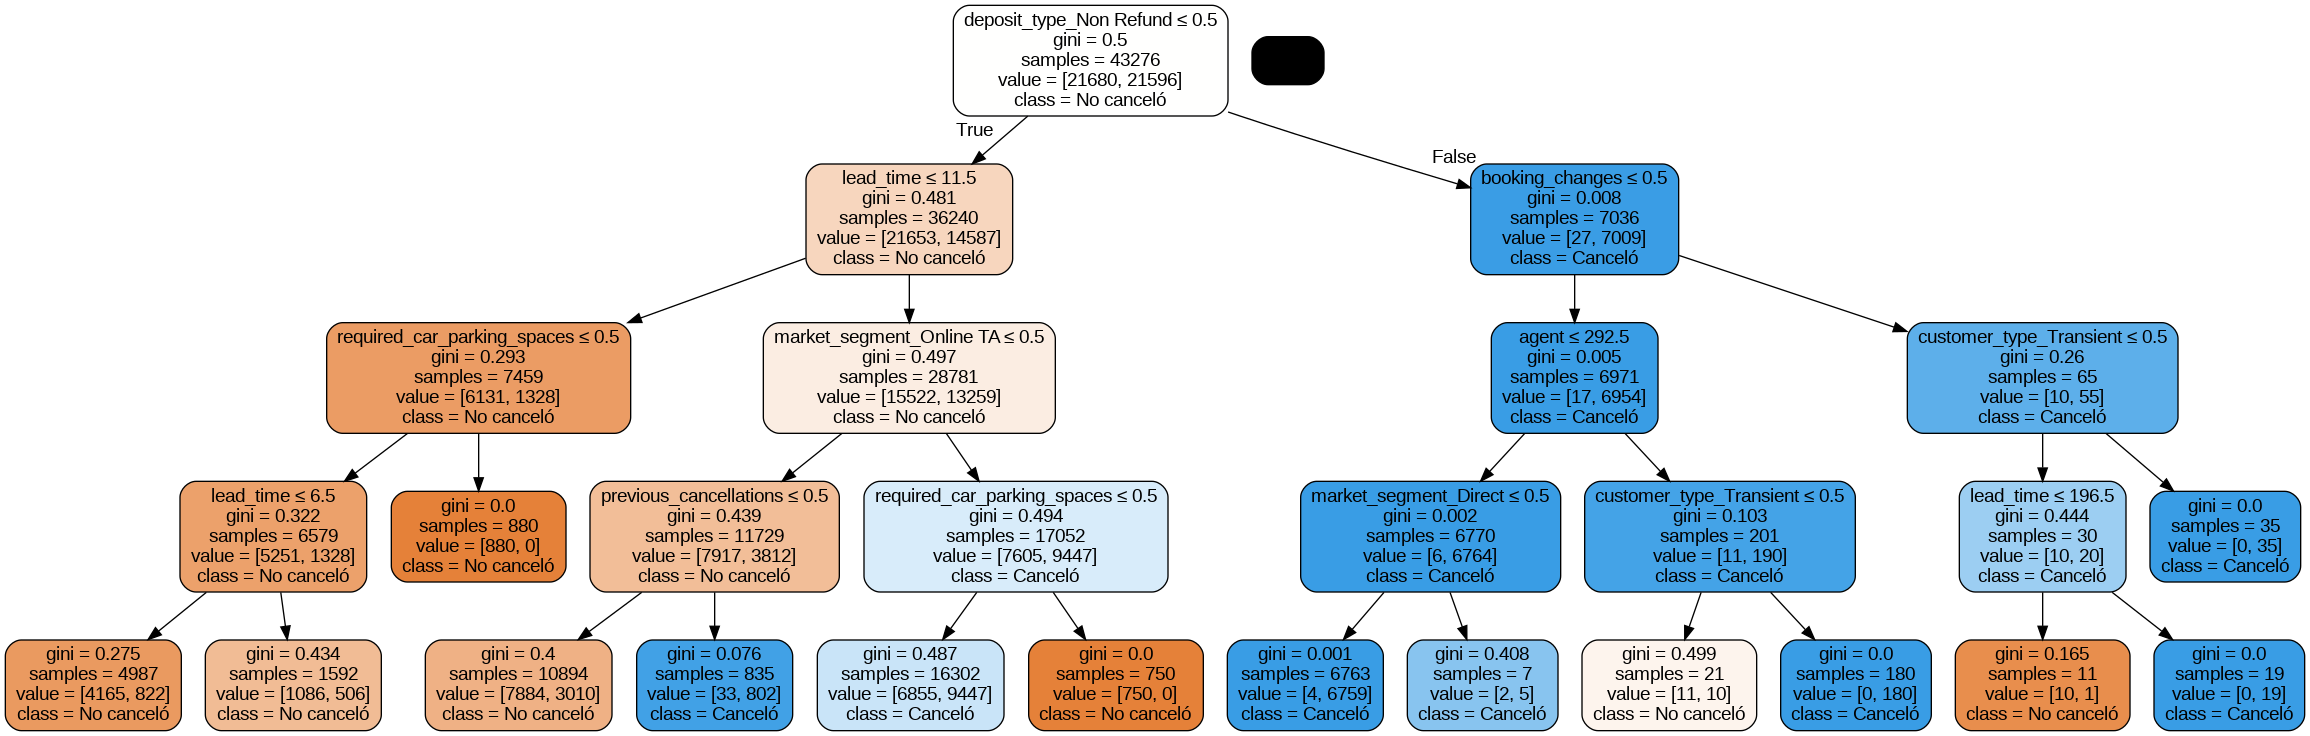

In [44]:
dot_data = StringIO()
export_graphviz(grid_tree_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=nombres_cols,
                class_names=['No canceló','Canceló'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Para tener un analisis más detallado de nuestro árbol, vemos en un gráfico la importancia de las variables.**

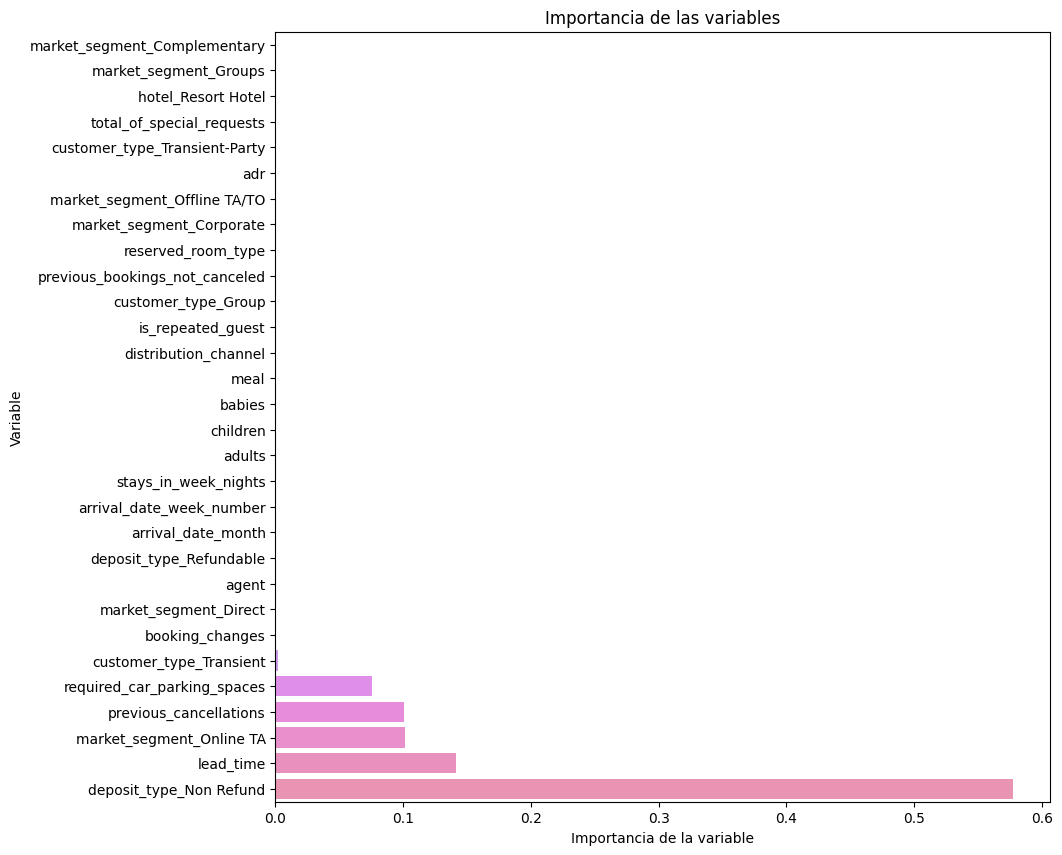

In [45]:
importancia_columna = pd.DataFrame(zip(nombres_cols,grid_tree_best.feature_importances_), columns=['Variable','Importancia de la variable'])
importancia_columna.sort_values(['Importancia de la variable'], axis=0, inplace=True)

plt.figure(figsize=(10, 10))
sns.barplot(y=importancia_columna['Variable'], x=importancia_columna['Importancia de la variable'])
plt.xlabel('Importancia de la variable')
plt.ylabel('Variable')
plt.title('Importancia de las variables')
plt.show()


In [46]:
importancia_columna = pd.DataFrame(zip(nombres_cols,grid_tree_best.feature_importances_), columns=['Variable','Importancia de la variable'])
importancia_columna.sort_values(['Importancia de la variable'], axis=0, inplace=True)

print(importancia_columna.to_string(index=False))


                      Variable  Importancia de la variable
  market_segment_Complementary                    0.000000
         market_segment_Groups                    0.000000
            hotel_Resort Hotel                    0.000000
     total_of_special_requests                    0.000000
 customer_type_Transient-Party                    0.000000
                           adr                    0.000000
  market_segment_Offline TA/TO                    0.000000
      market_segment_Corporate                    0.000000
            reserved_room_type                    0.000000
previous_bookings_not_canceled                    0.000000
           customer_type_Group                    0.000000
             is_repeated_guest                    0.000000
          distribution_channel                    0.000000
                          meal                    0.000000
                        babies                    0.000000
                      children                    0.0000

**Observación sobre las importancias**

Según las importancias de las características (features), la más importante en la predicción del modelo es la variable "deposit_type_Non Refund", seguida por "lead_time" y "required_car_parking_spaces". Estos resultados sugieren que la política de depósito no reembolsable es el factor más importante para determinar si un cliente cancelará una reserva o no. Además, el tiempo entre la fecha de reserva y la fecha de llegada y la disponibilidad de espacios de estacionamiento también influyen en la probabilidad de cancelación.

Las variables "total_of_special_requests" y "previous_cancellations" también son importantes para el modelo, pero en menor medida que las anteriores. Mientras que las variables "market_segment_Offline TA/TO", "required_car_parking_spaces" y "customer_type_Transient" tienen importancias moderadas en la predicción del modelo.

Por otro lado, las variables "agent", "market_segment_Direct" y "booking_changes" tienen la menor importancia en la predicción del modelo. Esto indica que estas variables no son tan relevantes para determinar si un cliente cancelará una reserva o no.

# Análisis de Modelos Obtenidos

In [47]:
import pandas as pd

# Crear dataframe con los resultados
resultados = pd.DataFrame({
    'Modelo': ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4: Grid Search'],
    'Parámetros': [
        "{'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0}",
        "{'max_depth': 9, 'criterion': 'entropy', 'ccp_alpha': 0.011111111111111112}",
        "{'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0.005555555555555556}",
        "{'max_depth': 4, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5}"
    ],
    'F1-Score': ['0.718', '0.717', '0.733', '0.755']
})

# Imprimir dataframe como tabla
print(resultados.to_markdown(index=False))


| Modelo                | Parámetros                                                                           |   F1-Score |
|:----------------------|:-------------------------------------------------------------------------------------|-----------:|
| Modelo 1              | {'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0}                           |      0.718 |
| Modelo 2              | {'max_depth': 9, 'criterion': 'entropy', 'ccp_alpha': 0.011111111111111112}          |      0.717 |
| Modelo 3              | {'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0.005555555555555556}          |      0.733 |
| Modelo 4: Grid Search | {'max_depth': 4, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5} |      0.755 |


Según los valores obtenidos, el modelo 4 con Grid Search es mejor que los otros modelos debido a que se ajustó de manera óptima los hiperparámetros de acuerdo a la métrica de evaluación (precisión) y a través de la validación cruzada. Es decir, se buscó el conjunto de parámetros que mejor ajustaran el modelo al conjunto de datos de entrenamiento y al mismo tiempo se evitó el sobreajuste del modelo.

Además, se puede observar que el F1 score obtenido por el modelo 4 (0.7547) es superior al obtenido por los otros modelos (0.7180, 0.7171 y 0.7330), lo que indica que el modelo 4 tiene una mejor capacidad predictiva.

#Preparacion del dataset para realizar predicciones

In [48]:
#importamos el conjunto de test real y le hacemos una copia
ds = pd.read_csv('https://drive.google.com/uc?export=download&id=1L-GDEKGbwtLMdYKCxhrJ9m4HZ5NIr5i2', index_col=None)
ds_x_test = ds.copy()

#hacemos sobre este el mismo trabajo que hicimos con el de entrenamiento
ds_x_test = pd.get_dummies(ds_x_test, columns=["hotel","deposit_type","customer_type", "market_segment"], drop_first=True)
ds_x_test['meal'] = ds_x_test['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

ds_x_test['distribution_channel'] = ds_x_test['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

ds_x_test['reserved_room_type'] = ds_x_test['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
                                                                   'H': 7, 'L': 8, 'P':9})

ds_x_test.drop(to_drop, axis = 'columns', inplace = True) #usamos la misma variable to_drop del principio del archivo
ds_x_test.fillna(0, inplace=True)

# Definimos el diccionario que asigna un número a cada mes
diccionario_meses = {
  'january': '1',
  'february': '2',
  'march': '3',
  'april': '4',
  'may': '5',
  'june': '6',
  'july': '7',
  'august': '8',
  'september': '9',
  'october': '10',
  'november': '11',
  'december': '12'
}

# Definimos la función que convierte un nombre de mes en su número correspondiente
def mes_a_numero(mes):
  if pd.isna(mes):
    return mes
  elif mes.lower() in diccionario_meses:
    return diccionario_meses[mes.lower()]
  else:
    return mes

# Aplicamos la funcion y convertimos los numeros a enteros en vez de strings
ds_x_test['arrival_date_month'] = ds_x_test['arrival_date_month'].apply(mes_a_numero).astype(int)

#Realizamos las predicciones
ds_y_test = tree_gs.predict(ds_x_test)

In [49]:
#agregamos la columna id que es nuestro identificador
ds_submission = pd.DataFrame({'id': ds['id'], 'is_canceled': ds_y_test})
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


Finalmente exportamos nuestras predicciones ya listas para publicar.

In [50]:
ds_submission.to_csv('Hotel_Reservas_4Submission.csv', index=False)


Nota: obtuvimos mejores metricas con otros arboles, como grid search con una maxima profundidad de 16, pero considerabamos que era muy excesivo, ya que testeaba muchas veces sobre las mismas columnas.